Импорт библиотек

In [1]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Загрузили датасеты, убрали ненужную колонку, привели к формату datetime и отлогарифмировали таргет.

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df.drop(['dropoff_datetime'], axis=1, inplace=True) # Убрали ненужную колонку
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) # Преобразовали в формат datetime
df['log_trip_duration'] = np.log1p(df['trip_duration']) # добавили лог шкалу для таргета
df.drop(['trip_duration'], axis=1) # убрали не таргет колонку

y_train = df['log_trip_duration'] # таргет отдельно

## Некоторые графики предварительного анализа

Распределение таргета, 99 персентиль.

<function matplotlib.pyplot.show(close=None, block=None)>

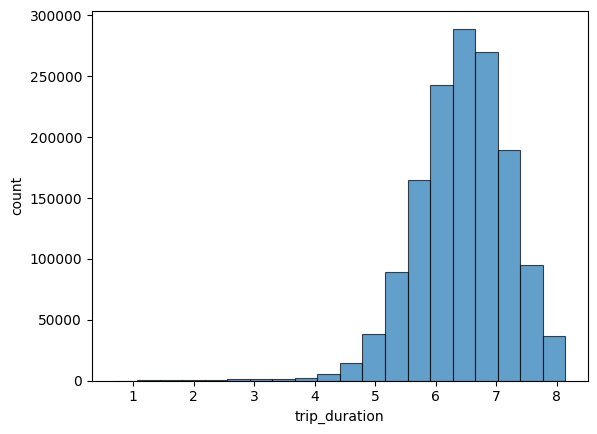

In [3]:
plt.hist(y_train[y_train < np.percentile(y_train, 99)], bins=20, linewidth=0.8, alpha=0.7, edgecolor='black')
plt.xlabel('trip_duration')
plt.ylabel('count')
plt.show

Количество поездок в каждый из дней периода сбора данных

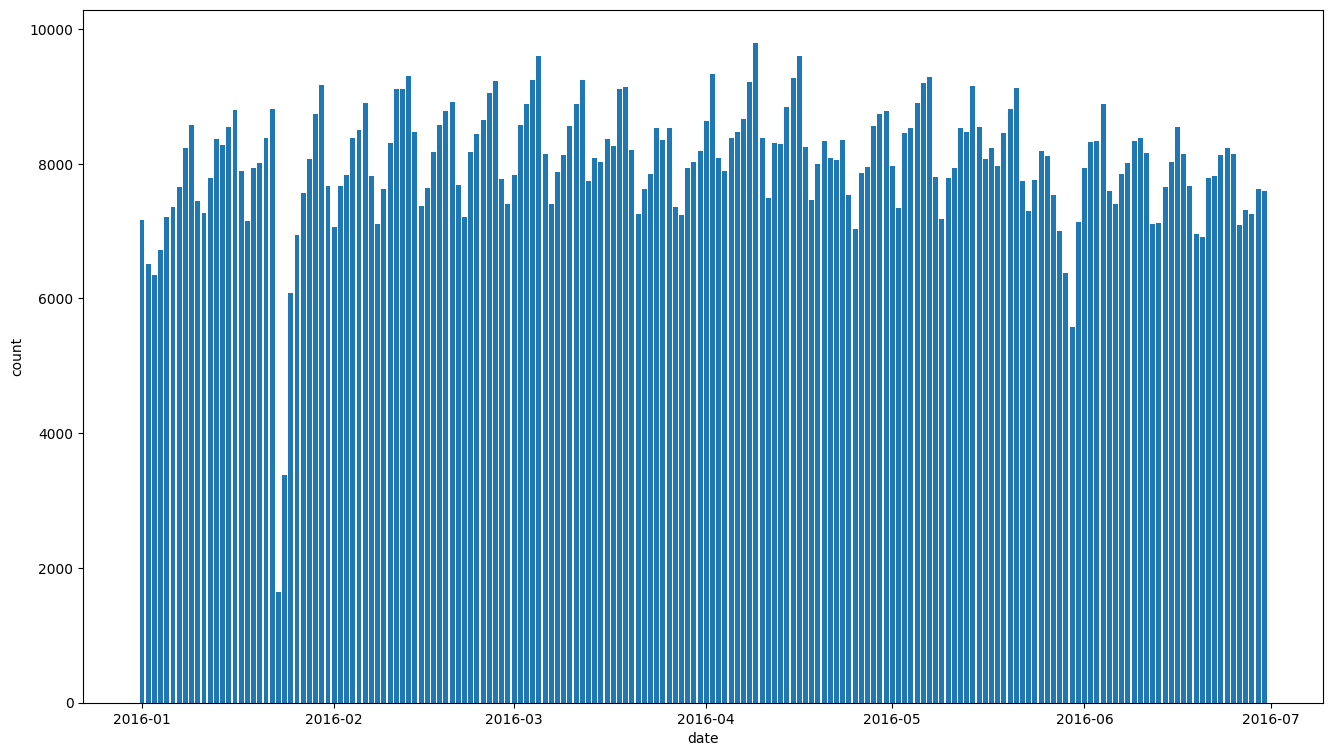

In [18]:
frequencies = df['pickup_datetime'].dt.date.value_counts()
fig, axs = plt.subplots(figsize=(16, 9))
axs.bar(height=frequencies.values, x=frequencies.index)
axs.set_xlabel('date')
axs.set_ylabel('count')
plt.show()

Здесь видно что есть два периода с аномально низким количеством поездок. В эти дни в городе была буря.

In [5]:
df0 = df.copy() # скопировали датафрейм для построения графика
df0['month'] = df0['pickup_datetime'].dt.month
df0['hour'] = df0['pickup_datetime'].dt.hour

month_hour_freq = df0[['month', 'hour']].value_counts() # количество поездок в зависимости от часа и месяца

month_hour_freq.sort_index(inplace=True)

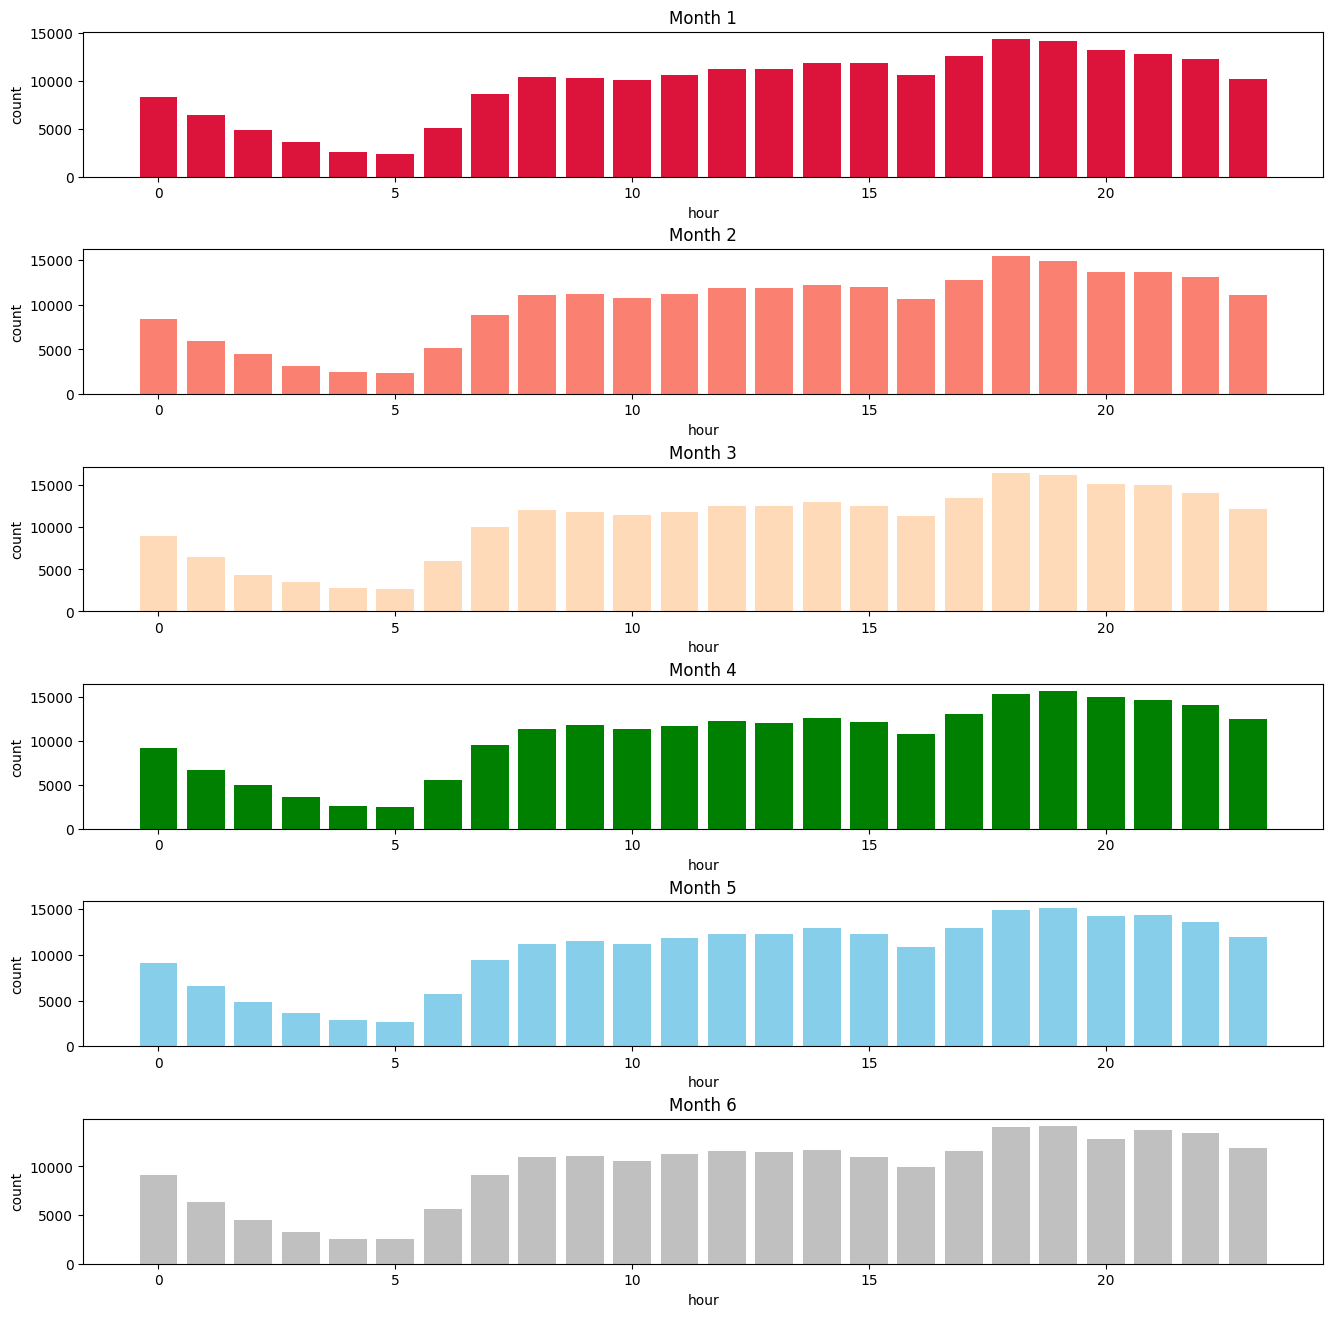

In [9]:
fig, axs = plt.subplots(6, 1, figsize=(16,16))
colors = ['crimson', 'salmon', 'peachpuff', 'green', 'skyblue', 'silver']
for i in range(6):
    axs[i].bar(height=month_hour_freq.loc[i+1].values, x=month_hour_freq.loc[i+1].index, color=colors[i])
    axs[i].set_title(f'Month {i+1}')
    axs[i].set_ylabel('count')
    axs[i].set_xlabel('hour')

plt.subplots_adjust(hspace=0.5)

plt.show()

На этих графиках почти всегда совпадают часы минимума и максимума. Количество поездок значительно уменьшается в позднее время и пик приходится на вечернее. Возможно это связано с рабочим расписанием, вечером люди уходят с работы например. В некоторые месяцы максимум несколько ниже (Июнь). В целом от месяца к месяцу поведение таргета не меняется.

---

График зависимости среднего логарифма таргета от часа. Все значения y были уменьшены на 6.

<function matplotlib.pyplot.show(close=None, block=None)>

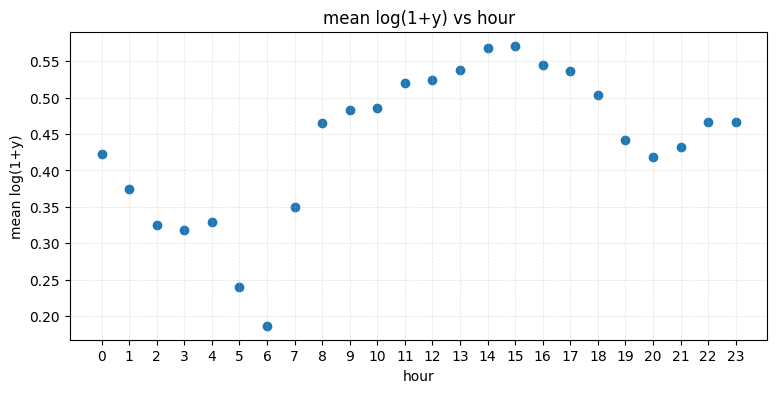

In [14]:
log_trip_vs_hour = df.groupby(df['pickup_datetime'].dt.hour)['log_trip_duration'].mean() - 6

fig, ax = plt.subplots(figsize=(9, 4))
ax.grid(linestyle='--', linewidth=0.5, alpha=0.4)
ax.scatter(x=log_trip_vs_hour.index, y=log_trip_vs_hour.values)
ax.set_title('mean log(1+y) vs hour')
ax.set_ylabel('mean log(1+y)')
ax.set_xlabel('hour')
plt.xticks(np.arange(24))
plt.show

В целом положение максимумов и минимумов приблизительно совпадает с аналогичными точками на графиках выше. 

Если пронумировать все дни наблюдаемого периода и построить график зависимости с логарифмированным таргетом уменьшенным на 6 получается увидеть некоторый тренд.

<function matplotlib.pyplot.show(close=None, block=None)>

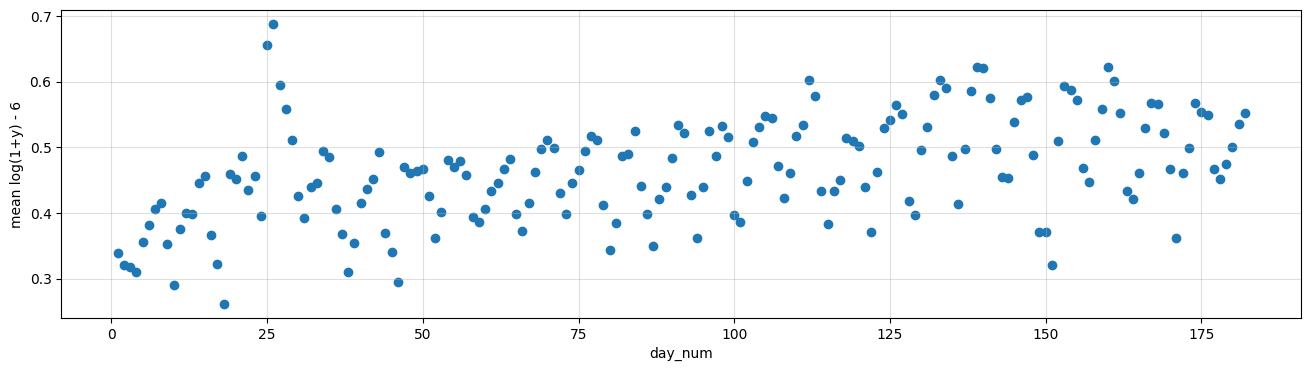

In [17]:
log_trip_vs_day_num = df.groupby(df['pickup_datetime'].dt.day_of_year)['log_trip_duration'].mean() - 6

fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(x=log_trip_vs_day_num.index, y=log_trip_vs_day_num.values)
ax.set_xlabel('day_num')
ax.set_ylabel('mean log(1+y) - 6')
ax.grid(True, alpha = 0.4)
plt.show

В те дни аномального периода с очень низким количеством поездок длительность их резко возрастает. В эти дни была сильная метель, это отражается в этих данных.

## Работа с признаками

Функция расчета расстояния на сфере, с векторизованными вычислениями.

In [3]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

Новый признак - haversine distance

In [4]:
df['haversine'] = haversine_array(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

Средняя скорость движения, в дальнейшем этот признак мы удалим так как он получается из таргета и другого признака $t = \frac{s}{v}.$

In [5]:
df['avg_speed'] = np.round(df['haversine'] * 3600 / df['trip_duration'], 1)

Построим heatmap - график зависимости медианной скорости от часа и дня недели.

<Axes: xlabel='hour', ylabel='day_of_week'>

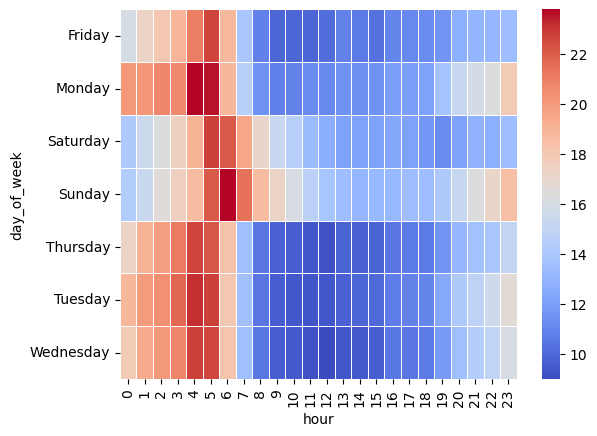

In [6]:
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour

avg_speed_vs_day_hour = df.groupby(by=['day_of_week', 'hour'])['avg_speed'].median()

sns.heatmap(avg_speed_vs_day_hour.unstack(level=-1), cmap='coolwarm', linewidths=0.5)

По этому графику мы построим новый **признак**: началась ли поездка в момент загруженного трафика или наоборот, в период свободных дорог.

In [7]:
df['traffic_jam_high'] = (df['day_of_week'].isin({'Wednesday', 'Tuesday', 'Thursday'}) & df['hour'].isin({9, 10, 11, 12, 13})).astype(int)
df['traffic_jam_low'] = ((df['day_of_week'].isin({'Monday'}) & df['hour'].isin({4, 5})) | (df['day_of_week'].isin({'Sunday'}) & df['hour'].isin({6}) ) ).astype(int)

Как уже было сказано в pdf - описании, есть две точки на карте Нью - Йорка находящиеся слишком далеко от всех остальных точек начала поездок.

Выделим эти две точки и сделаем на их основании **признаки**: началась/закончилась ли поездка в одной из этих особых точек.

4.58, 4.5 - это грубые оценки размера аэропортов - этих особых точек.

In [8]:
df['ended_at_Kennedy'] = (haversine_array(df['pickup_latitude'], df['pickup_longitude'], 40.64, -73.78) < 4.58).astype(int)
df['started_at_Kennedy'] = (haversine_array(df['dropoff_latitude'], df['dropoff_longitude'], 40.64, -73.78) < 4.58).astype(int)

In [9]:
df['ended_at_Newark'] = (haversine_array(df['pickup_latitude'], df['pickup_longitude'], 40.6925, -74.1687) < 4.5).astype(int)
df['started_at_Newark'] = (haversine_array(df['dropoff_latitude'], df['dropoff_longitude'], 40.6925, -74.1687) < 4.5).astype(int)

"Ящики с усами" для этих признаков

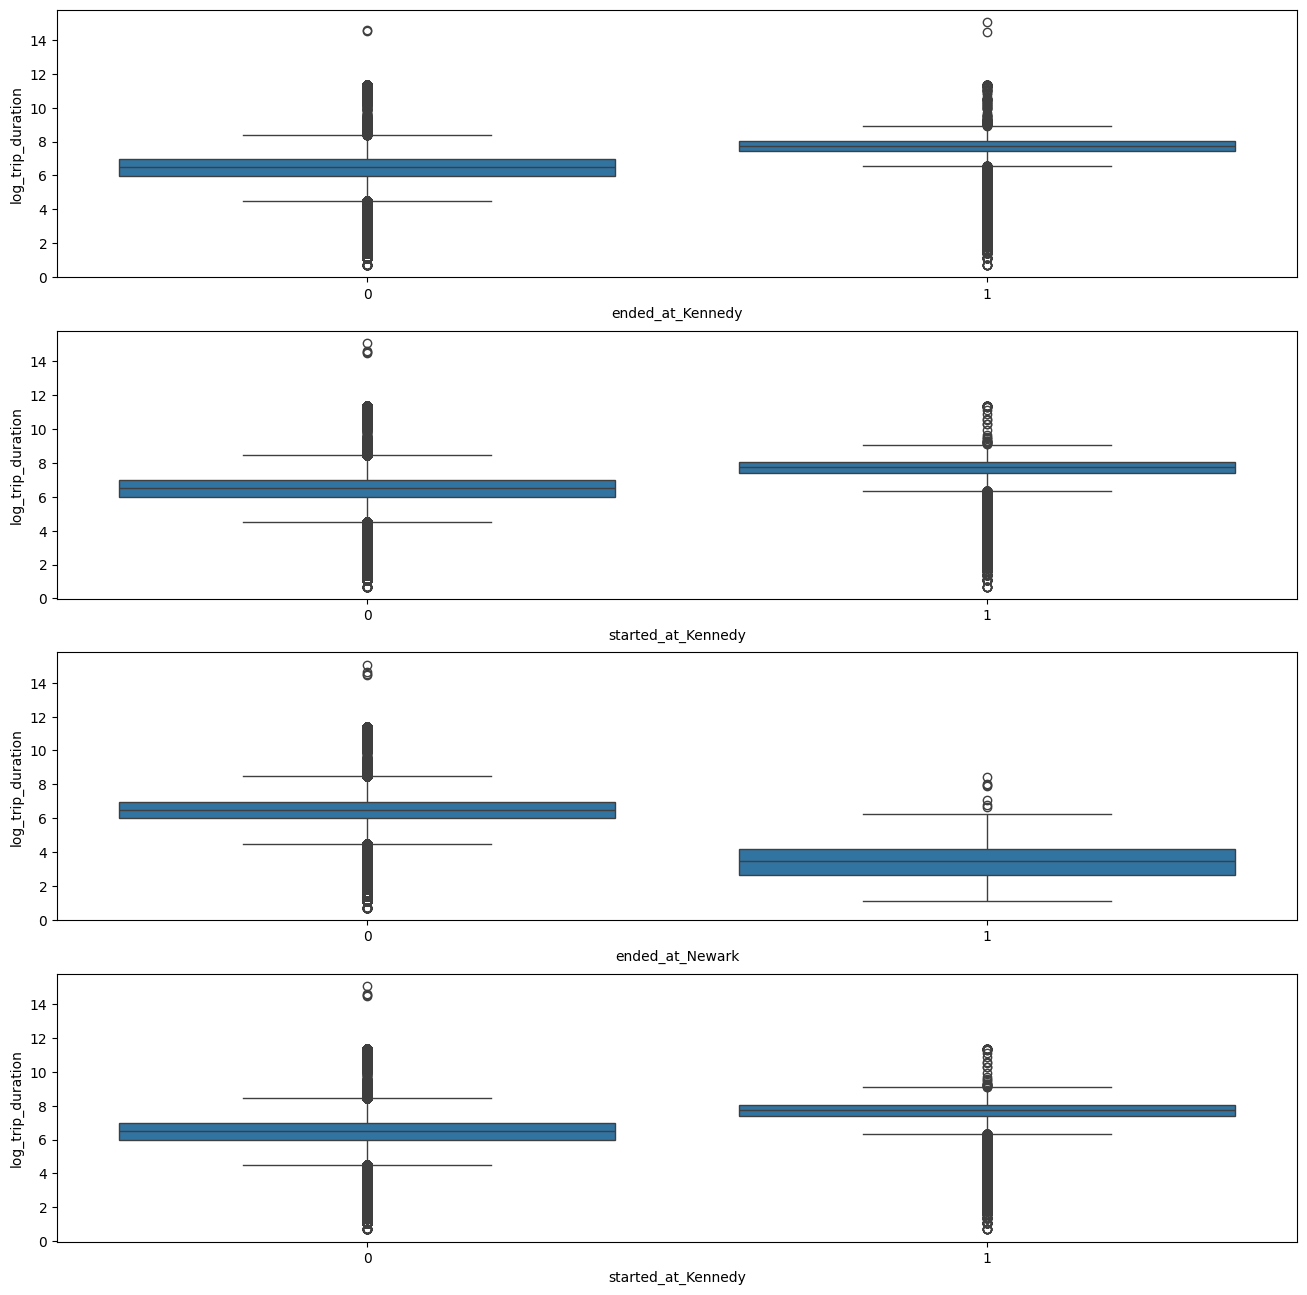

In [11]:
features_airport = ['ended_at_Kennedy', 'started_at_Kennedy', 'ended_at_Newark', 'started_at_Kennedy']

fig, ax = plt.subplots(4,1 , figsize=(16, 16))

for i, feature in enumerate(features_airport):
    sns.boxplot(ax=ax[i], data=df, x=df[feature], y=df['log_trip_duration'])

Как видно, медианное время поездки действительно зависит от того началась ли поездка в одной из этих точек.

**Сетка** \
Еще один признак строится следующим образом: мы выбираем прямоугольную область и делим ее на сегменты, m на n штук. Далее классифицируем точку начала и конца поездки как $(i,j)$ - номер сегмента.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    # прямоугольник строится по двум точкам
    def __init__(self, lat_min, lon_min, lat_max, lon_max, m, n):
        self.lat_min = lat_min
        self.lon_min = lon_min
        self.lat_max = lat_max
        self.lon_max = lon_max
        self.m = m
        self.n = n

    def fit(self, X, y=None):
        self.lat_edges = np.linspace(self.lat_min, self.lat_max, self.m + 1)
        self.lon_edges = np.linspace(self.lon_min, self.lon_max, self.n + 1)
        return self

    def transform(self, X):
        # X это массив размера (2, N)
        if hasattr(X, 'to_numpy'):
            X = X.to_numpy()

        lats = X[:, 0]
        lons = X[:, 1]

        # с помощью сортировки находим в какие границы попадают долгота и широта точки
        lat_idx = np.searchsorted(self.lat_edges, lats, side='right') - 1
        lon_idx = np.searchsorted(self.lon_edges, lons, side='right') - 1

        # если не попало ни в одну - то -1
        out_of_range = ((lats < self.lat_edges[0]) | (lats >= self.lat_edges[-1])) | ((lons < self.lon_edges[0]) | (lons >= self.lon_edges[-1]))
        lat_idx[out_of_range] = -1
        lon_idx[out_of_range] = -1

        return np.stack((lat_idx, lon_idx), axis=1)

## Обучение

Итак, снова наши признаки

In [14]:
df['haversine'] = haversine_array(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
df['haversine_log'] = np.log1p(df['haversine'])
df.drop(['haversine'], inplace=True, axis=1)
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour

df['ended_at_Kennedy'] = (haversine_array(df['pickup_latitude'], df['pickup_longitude'], 40.64, -73.78) < 4.58).astype(int)
df['started_at_Kennedy'] = (haversine_array(df['dropoff_latitude'], df['dropoff_longitude'], 40.64, -73.78) < 4.58).astype(int)

df['ended_at_Newark'] = (haversine_array(df['pickup_latitude'], df['pickup_longitude'], 40.6925, -74.1687) < 4.5).astype(int)
df['started_at_Newark'] = (haversine_array(df['dropoff_latitude'], df['dropoff_longitude'], 40.6925, -74.1687) < 4.5).astype(int)

df['traffic_jam_high'] = (df['day_of_week'].isin({'Wednesday', 'Tuesday', 'Thursday'}) & df['hour'].isin({9, 10, 11, 12, 13})).astype(int)
df['traffic_jam_low'] = ((df['day_of_week'].isin({'Monday'}) & df['hour'].isin({4, 5})) | (df['day_of_week'].isin({'Sunday'}) & df['hour'].isin({6}) ) ).astype(int)

Классифицируем начало и конец поездки по номеру сегмента, сетка размера 5 на 12.

In [15]:
transformer = MapGridTransformer(40.700135, -74.016527, 40.805399, -73.931862, 5, 12)
df_2 = df.copy()

lat_lon = transformer.fit_transform(df_2[['pickup_latitude', 'pickup_longitude']])
lat_lon_dropoff = transformer.fit_transform(df_2[['dropoff_latitude', 'dropoff_longitude']])
df_2["cell_idx_pickup"] = [
    str((int(i), int(j))) for i, j in zip(lat_lon[:, 0], lat_lon[:, 1])
]

df_2["cell_idx_dropoff"] = [
    str((int(i), int(j))) for i, j in zip(lat_lon_dropoff[:, 0], lat_lon_dropoff[:, 1])
]

Импорт библиотек

In [17]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

One-hot encoding категориальных признаков.

In [18]:
X_part2 = df_2[['day_of_week', 'hour', 'traffic_jam_high',
       'traffic_jam_low', 'ended_at_Kennedy', 'started_at_Kennedy',
       'ended_at_Newark', 'started_at_Newark', 'cell_idx_pickup',
       'cell_idx_dropoff', 'haversine_log']].copy()

categorical = ['day_of_week', 'hour', 'cell_idx_pickup',
       'cell_idx_dropoff']

enc_part2 = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

array_encoded = enc_part2.fit_transform(X_part2[categorical]) # вывод будет массивом, нам нужен датафрейм
pd_data = pd.DataFrame(array_encoded, columns=enc_part2.get_feature_names_out(), dtype=int) # привели к типу dataframe

X_encoded_part2 = pd.concat([X_part2, pd_data], axis=1) # concat с изначальной таблицей
X_encoded_part2.drop(categorical, axis=1, inplace=True) # убрали закодированные столбцы
X_encoded_part2

,traffic_jam_high,traffic_jam_low,ended_at_Kennedy,started_at_Kennedy,ended_at_Newark,started_at_Newark,haversine_log,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,...,"cell_idx_dropoff_(4, 10)","cell_idx_dropoff_(4, 11)","cell_idx_dropoff_(4, 2)","cell_idx_dropoff_(4, 3)","cell_idx_dropoff_(4, 4)","cell_idx_dropoff_(4, 5)","cell_idx_dropoff_(4, 6)","cell_idx_dropoff_(4, 7)","cell_idx_dropoff_(4, 8)","cell_idx_dropoff_(4, 9)"
0,0,0,0,0,0,0,0.915699,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1.031584,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1.999464,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0.910473,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0.783257,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,0,0,0,0,0,0,0.799793,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1458640,0,0,0,0,0,0,1.953004,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1458641,0,0,0,0,0,0,2.177544,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1458642,0,0,0,0,0,0,0.738390,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

Сплитим выборку

In [21]:
y = df['log_trip_duration']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_part2, y, test_size=0.3) # Разбили выборку на тестовую и обучающую

Скейлинг числовых признаков

In [23]:
scaler = StandardScaler()

numerical_features = ['haversine_log']
X_train[numerical_features] = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]), columns=numerical_features, index=X_train.index)
X_test[numerical_features] = pd.DataFrame(scaler.transform(X_test[numerical_features]), columns=numerical_features, index=X_test.index)


Обучение Ridge регрессии.

In [25]:
model = Ridge()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
constant_pred = y_train.mean()

error = np.round(root_mean_squared_error(y_test, y_pred), 3)
error_train = np.round(root_mean_squared_error(y_train, y_train_pred), 3)
error_constant = np.round(root_mean_squared_error(y_test, pd.Series(constant_pred * np.ones(len(y_test)))), 3)

print(f'test error RMSE = {error}')
print(f'train error RMSE = {error_train}')
print(f'constant prediction error RMSE = {error_constant}')

test error RMSE = 0.477
train error RMSE = 0.477
constant prediction error RMSE = 0.795


## Работа с аномальными объектами

Убираем выбросы в обучающей выборке с большим остатком регрессии, слишком большим временем поездки, аномальным расстоянием.

Распределение остатка регрессии, 99.9 персентиль

<Axes: xlabel='log_trip_duration', ylabel='Count'>

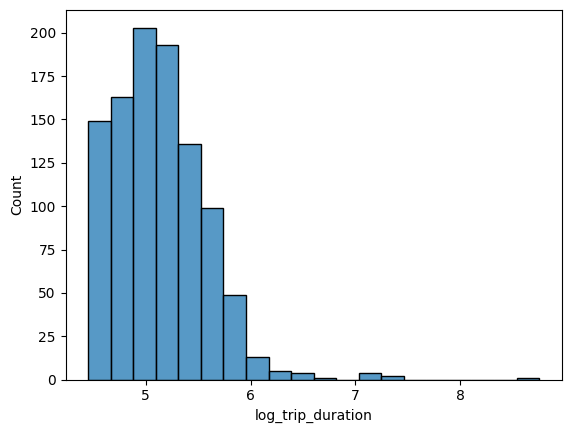

In [26]:
diff = y_train - y_train_pred

sns.histplot(diff[diff > np.percentile(diff, 99.9)], bins=20)

Распределение времени поездки, 99.9 персентиль.

<Axes: xlabel='trip_duration', ylabel='Count'>

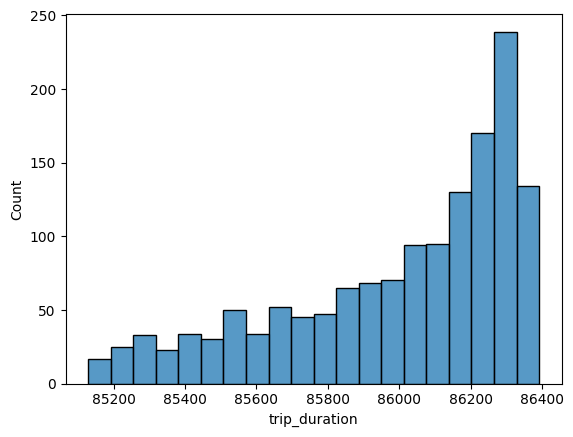

In [27]:
sns.histplot(df['trip_duration'][(df['trip_duration'] > np.percentile(df['trip_duration'], 99.9)) & (df['trip_duration'] < 200000)], bins=20)

Тоже самое для расстояния.

<Axes: xlabel='haversine_log', ylabel='Count'>

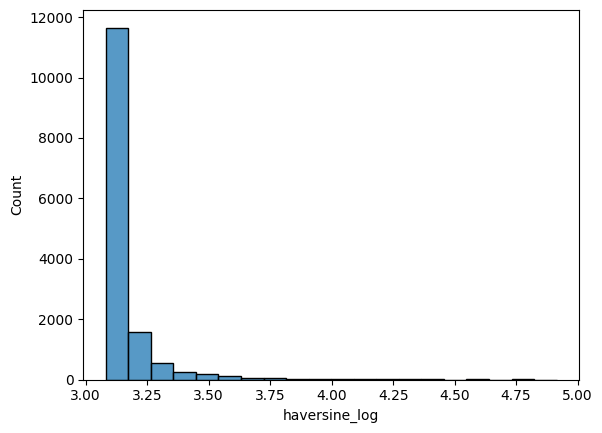

In [29]:
sns.histplot(df['haversine_log'][(df['haversine_log'] > np.percentile(df['haversine_log'], 99)) & (df['haversine_log'] < 5)], bins=20)

Очищаем тренировочную выборку от выбросов.

In [30]:
mask = y_train[y_train < np.percentile(y_train, 99.9)].index

X_train_discarded = X_train.loc[(X_train['haversine_log'] < np.percentile(X_train['haversine_log'], 99))
                            & X_train.index.isin(mask) & X_train.index.isin(diff.index)]

In [31]:
indices = X_train.loc[(X_train['haversine_log'] < np.percentile(X_train['haversine_log'], 99))
                            & X_train.index.isin(mask) & X_train.index.isin(diff.index)].index

y_train_discarded = y_train[y_train.index.isin(indices)]

### Объединяем редкие категории в одну.

Есть категории с с очень редким присутствием в выборке.

In [32]:
df['passenger_count'].value_counts()

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

In [33]:
a = df_2['cell_idx_pickup'].value_counts()
a[a < 20]

cell_idx_pickup
(3, 0)    7
(1, 7)    7
(4, 0)    5
(3, 1)    4
(4, 2)    2
(4, 1)    1
Name: count, dtype: int64

In [34]:
b = df_2['cell_idx_dropoff'].value_counts()
b[b < 23]

cell_idx_dropoff
(3, 0)    22
(1, 7)    18
(4, 1)    17
(4, 2)    13
(3, 1)    11
(4, 0)    10
(4, 3)     7
Name: count, dtype: int64

Мы объединим их в одну категорию.


In [35]:
cols_with_rare_cat = ['cell_idx_dropoff_(3, 0)', 'cell_idx_dropoff_(1, 7)', 'cell_idx_dropoff_(4, 1)', 'cell_idx_dropoff_(4, 2)',
                      'cell_idx_dropoff_(3, 1)', 'cell_idx_dropoff_(4, 0)', 'cell_idx_dropoff_(4, 3)',
                      'cell_idx_pickup_(3, 0)', 'cell_idx_pickup_(1, 7)', 'cell_idx_pickup_(4, 0)', 'cell_idx_pickup_(3, 1)',
                      'cell_idx_pickup_(4, 2)', 'cell_idx_pickup_(4, 1)']

In [36]:
X_train_discarded['rare_categories'] = (X_train_discarded[cols_with_rare_cat] == 1).any(axis=1).astype(int)

X_train_discarded_final = X_train_discarded.copy()
X_train_discarded_final.drop(cols_with_rare_cat, axis=1, inplace=True)

C:\Users\K\AppData\Local\Temp\ipykernel_25024\4053192769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_discarded['rare_categories'] = (X_train_discarded[cols_with_rare_cat] == 1).any(axis=1).astype(int)


In [37]:
X_test_modified = X_test.copy()
X_test_modified['rare_categories'] = (X_test[cols_with_rare_cat] == 1).any(axis=1).astype(int)
X_test_modified.drop(cols_with_rare_cat, axis=1, inplace=True)

Обучение

In [40]:
model = Ridge()

model.fit(X_train_discarded_final, y_train_discarded)
y_pred = model.predict(X_test_modified)
y_train_pred = model.predict(X_train_discarded_final)
constant_pred = y_train.mean()

error = np.round(root_mean_squared_error(y_test, y_pred), 3)
error_train = np.round(root_mean_squared_error(y_train_discarded, y_train_pred), 3)
error_constant = np.round(root_mean_squared_error(y_test, pd.Series(constant_pred * np.ones(len(y_test)))), 3)

print(f'test error RMSE = {error}')
print(f'train error RMSE = {error_train}')
print(f'constant prediction error RMSE = {error_constant}')

test error RMSE = 0.477
train error RMSE = 0.452
constant prediction error RMSE = 0.795


Показатель качества улучшился на обучающей выборке, но не на тестовой.

## GridSearch

In [41]:
from sklearn.model_selection import GridSearchCV

Валидационная выборка в соотношении 8 к 2.

In [42]:
X_valid, X_train_valid, y_valid, y_train_valid = train_test_split(X_train_discarded, y_train_discarded, train_size=0.2)

In [43]:
alphas = np.linspace(0, 10, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_valid, y_valid)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 0.5263


Обучение с best-alpha.

In [44]:
model = Ridge(alpha = 0.5263)

model.fit(X_train_discarded_final, y_train_discarded)
y_pred = model.predict(X_test_modified)
y_train_pred = model.predict(X_train_discarded_final)
constant_pred = y_train.mean()

error = np.round(root_mean_squared_error(y_test, y_pred), 3)
error_train = np.round(root_mean_squared_error(y_train_discarded, y_train_pred), 3)
error_constant = np.round(root_mean_squared_error(y_test, pd.Series(constant_pred * np.ones(len(y_test)))), 3)

print(f'test error RMSE = {error}')
print(f'train error RMSE = {error_train}')
print(f'constant prediction error RMSE = {error_constant}')

test error RMSE = 0.477
train error RMSE = 0.451
constant prediction error RMSE = 0.795
